# Introduction
The code is split into a few main sections. We first prep the imported data files. Then we create various functions that can be used in a data processing pipeline. Finally, we use the processed data for modeling.
1. Data Prep:
    - Here is where the various csv and xslx files needed for the code are loaded and processed. 
    - Each file has its own section for processing
2. Data Pipeline Steps:
    - This section of the code contains all of our data pipeline steps. These are simply Python functions that take a dataframe as an input, and output a dataframe
    - The steps have been split into various functions to enable the user to customize feature creation
        - This was important for us to be able to collaboratively work on the code together, enabling us to easily drop in new feature engineering and data processing steps into the code for each other.
    - Use of the pipeline steps will be helpful in deployment, when historical data will need to be processed differently from input data (input data being the csv of flights we are predicting on)
3. Run Pipeline
    - Here, we simply run the data pipeline, using a number of steps that we designed to create a fully processed data file. 
    - In this section we also create our train/test/validation split
4. Modeling
    - For the sake of simplicity, this file has been limited to RandomForest, LightGBM, and also a GaussianNB model for benchmark comparison

# Setup (Imports)

In [30]:
# helpful tool for tracking the total time it takes to run the code on varied machines
import time

start_time = time.time()

In [31]:
# import all packages used throughout the code
# This is a complete list of all packages that need to be imported for use throughout the code
import pandas as pd
from itertools import product
from skopt import BayesSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from skopt.space import Real, Categorical, Integer
import matplotlib.pyplot as plt
from datetime import datetime
import math
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler
import gc
import string
import holidays
import re
from pycountry_convert import country_alpha2_to_country_name
import pycountry
from haversine import haversine, Unit
from sklearn.feature_selection import RFE
import joblib
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor

In [32]:
# function to calculate MAPE from actual and predicted y values
def mean_absolute_percentage_error(y_true, y_pred, epsilon):    
    # Avoid creating intermediate variables unnecessarily
    absolute_errors = np.abs(y_true - y_pred)
    
    # Avoid adding epsilon to each element separately
    y_true_e = y_true + epsilon
    percentage_errors = absolute_errors / y_true_e
    
    mape = np.mean(percentage_errors) * 100
    return mape

# Data Prep

## Import

In [33]:
# Main dataset with the number of meals per meal code per cabin per flight
# Source: Delta
mealsPerFlight = pd.read_csv('data/MealsPerFlight_20240104.csv', header=0)

# Additional dataset that contains capacity information regarding 
# Source: Extracted data from Delta PDF (extraction by Pamela Cheng)
capacity_info = pd.read_excel('data/Fleet Key_v1.xlsx', header=0)

# Additional dataset that associate airport IATA codes with their country and coordinates
# Source: https://github.com/datasets/airport-codes/blob/master/data/airport-codes.csv
airport_codes = pd.read_csv("data/airport-codes.csv", header=0)

# Passenger Load Data for retrieving flight times
passengerLoadData = pd.read_csv("data/passenger_load_data.csv", header=0)

## mealsPerFlight
This is the main dataset that we are using for the model, MealsPerFlight

In [34]:
# Ensure FlightDate is formatted as datetime in the df
mealsPerFlight['FlightDate'] = pd.to_datetime(mealsPerFlight['FlightDate'], errors='coerce')

# Strip whitespace from string columns for merging later
mealsPerFlight['FlightOrigin'] = mealsPerFlight['FlightOrigin'].str.strip()
mealsPerFlight['FlightDestination'] = mealsPerFlight['FlightDestination'].str.strip()
mealsPerFlight['EntreeType'] = mealsPerFlight['EntreeType'].str.strip()

## passengerLoadData
This is the passenger load data provided by Delta, which contains information on the takeoff time at the origin, as well as the capacity for each flight

In [35]:
# Convert date columns to datetime format
passengerLoadData['Flt_Orig_Dt'] = pd.to_datetime(passengerLoadData['Flt_Orig_Dt'])
passengerLoadData['Schd_Dprt_LTs'] = pd.to_datetime(passengerLoadData['Schd_Dprt_LTs'])
passengerLoadData['Schd_Arr_LTs'] = pd.to_datetime(passengerLoadData['Schd_Arr_LTs'])
passengerLoadData.drop(columns=['Index', 'Schd_Arr_LTs'], inplace=True)

# Rename columns for easier processing, merging later
flight_times = passengerLoadData.rename(columns={
    'Flt_Orig_Dt': 'FlightDate',
    'Flt_Nb': 'FlightNumber',
    'Schd_Orig_Stn_Cd': 'FlightOrigin',
    'Schd_Dest_Stn_Cd': 'FlightDestination',
    'Actl_Ac_Typ_Cd': 'AircraftType',
    'Dom_Intl_Cd': 'DomOrInt',
    'Schd_Dprt_LTs': 'DepartTime',
    'Pax_Ct': 'PassengerCount',
    'Seat_Avby_Ct': 'PassengerCapacity'
})

# Create new columns based on the values in 'DomOrInt'
# Can use these as features later to count the number of domestic and international flights in an aggregation
flight_times['IsDom'] = (flight_times['DomOrInt'] == 'D').astype(int) # is a domestic flight
flight_times['IsInt'] = (flight_times['DomOrInt'] == 'I').astype(int) # is an international flight
flight_times.drop(columns=['DomOrInt', 'PassengerCount'], inplace=True) # Drop the original 'DomOrInt' column

# Strip whitespace from FlightOrigin and FlightDestination -- important for merges later
flight_times['FlightOrigin'] = flight_times['FlightOrigin'].str.strip()
flight_times['FlightDestination'] = flight_times['FlightDestination'].str.strip()
flight_times['AircraftType'] = flight_times['AircraftType'].str.strip()

## capacity_info
At this time, we don't actually use the capacity_info dataset. However, depending on the format of the input data, returning to use of this DF may be important later.

In [36]:
# ensure correct variable types in datasets
capacity_info['Subfleet'] = capacity_info['Subfleet'].astype(str)
mealsPerFlight['AircraftType'] = mealsPerFlight['AircraftType'].astype(str)

In [37]:
# Columns which have dirty data (should be int but include non-numerical values)
columns_to_process = ['C', 'F', 'W', 'Y', 'Total']

# Convert columns to string
capacity_info[columns_to_process] = capacity_info[columns_to_process].astype(str)

# Extract only the numeric part before any non-numeric characters occur (most noise is something like "151(1)", we want to remove the "(1)")
for column in columns_to_process:
    capacity_info[column] = capacity_info[column].apply(lambda x: re.search(r'\d+', x).group() if re.search(r'\d+', x) else '')

# Convert columns to integers after fixing them
capacity_info[columns_to_process] = capacity_info[columns_to_process].astype(int)

## airport_codes
Here, we create a table of each airport IATA code, the country where the airport is located, and the coordinates of the airport

In [38]:
# Select only the necessary columns from the dataset
airport_codes = airport_codes[["iata_code", 'iso_country', 'coordinates']]

# Originally, coordinates are stored as a string like "latitude, longitude"
# Instead, store them as a tuple for easier access to each attribute
airport_codes['coordinates'] = airport_codes['coordinates'].apply(lambda x: tuple(map(float, x.split(', ')))) 

# Drop rows with missing values in the "iata_code" column
# There is a lot of data we don't need here, any airport that doesn't have an IATA code is unneccesary
# All of the airports in our mealsPerFlight df are identified by their IATA code
airport_codes = airport_codes.dropna(subset=["iata_code"])

## flight_distances
In order to save processing time later, we will pre-compute the distance in miles for each unique origin-destination pair by using the haversine distance based on the latitude and longitude of the origin and destination. This new table of flight distances can be merged with our mealsPerFlight dataset. The flight distance can be used as a feature later.

In [39]:
# Get unique combinations of FlightOrigin and FlightDestination
unique_combinations = mealsPerFlight[['FlightOrigin', 'FlightDestination']].drop_duplicates()

# Merge with airport_codes to get coordinates for origin
flight_distances = pd.merge(unique_combinations, airport_codes, left_on='FlightOrigin', right_on='iata_code', how='left')
flight_distances.rename(columns={'coordinates': 'OriginCoordinates', 'iso_country': 'OriginCountry'}, inplace=True)

# Merge with airport_codes to get coordinates for destination
flight_distances = pd.merge(flight_distances, airport_codes, left_on='FlightDestination', right_on='iata_code', how='left')
flight_distances.rename(columns={'coordinates': 'DestinationCoordinates', 'iso_country': 'DestinationCountry'}, inplace=True)

# Use tuples of latitude and longitude for origin and destination to compute haversine distance for each unique origin-destination pair
flight_distances['FlightDistance'] = flight_distances.apply(lambda row: haversine(row['OriginCoordinates'], row['DestinationCoordinates'], unit=Unit.MILES), axis=1)

# Splitting the origin coordinates into latitude and longitude
flight_distances[['OriginLatitude', 'OriginLongitude']] = flight_distances['OriginCoordinates'].apply(lambda x: pd.Series({'OriginLatitude': x[0], 'OriginLongitude': x[1]}))

# Splitting the destination coordinates into lat and long
flight_distances[['DestinationLatitude', 'DestinationLongitude']] = flight_distances['DestinationCoordinates'].apply(lambda x: pd.Series({'DestinationLatitude': x[0], 'DestinationLongitude': x[1]}))

# Drop now unneccessary columns
flight_distances.drop(columns=['iata_code_x', 'iata_code_y', 'OriginCoordinates', 'DestinationCoordinates'], inplace=True)

# Data Pipeline Steps

### In scope FlightOrigin, MealCode
Based on the information provided by Angela on March 3rd, 2024, we must reduce the scope of the dataset. As such, we've created a list for the in scope flight origins and meal codes. Then, we use a function to remove rows that do not fall within the scope of the project.

In [40]:
# Valid flight origins list (as provided by Delta)
valid_flight_origins = ['ANC', 'ATL', 'AUS', 'BDL', 'BNA', 'BOS', 'BWI', 'CLT', 'CMH', 'CVG', 'DCA', 'DEN', 'DFW', 'DTW', 'EWR', 'FLL', 'HNL', 'IAD', 'IAH', 'IND', 'JAX', 'JFK', 'KOA', 'LAS', 'LAX', 'LGA', 'MCI', 'MCO', 'MEM', 'MEX', 'MIA', 'MKE', 'MSP', 'MSY', 'OGG', 'ONT', 'ORD', 'PBI', 'PDX', 'PHL', 'PHX', 'PIT', 'PVD', 'RDU', 'RSW', 'SAN', 'SAT', 'SEA', 'SFO', 'SJC', 'SLC', 'SMF', 'SNA', 'STL', 'TPA']

# Valid meal codes list (as provided by Delta)
valid_meal_codes = ['AVML', 'VLML', 'BLML', 'CHML', 'DBML', 'GFML', 'HNML', 'KSML', 'LFML', 'LSML', 'MOML', 'VGML', 'TDML', 'BBML']

# Function to filter the dataframe to only include rows where the FlightOrigin and MealCode fall into the scope of the project
def in_scope_filtering(dataframe):
    scope_df = dataframe.copy()
    scope_df = scope_df[scope_df['FlightOrigin'].isin(valid_flight_origins)] # Filter for flight origins
    scope_df = scope_df[scope_df['MealCode'].isin(valid_meal_codes)] # Filter for mealcodes

    return scope_df

### Aggregate to ignore EntreeType
In the original dataset, there is a row for each meal served for each MealCode in each CabinCode of each flight. However, we want to predict the number of customers we need to serve -- not the number of meals we need to serve to each customer (although, in the aggregate model, we come closer to that in actuality)

In [41]:
# Function to aggregate to number of customers to serve
def aggregate_to_passenger_preference(dataframe):
    agg_df = dataframe.copy()

    # Group by the specified columns and aggregate
    agg_df = agg_df.groupby(['FlightDate', 'FlightOrigin', 'FlightDestination', 
                        'FlightNumber', 'AircraftType', 'MealCode', 
                        'CabinCode', 'CateredQuantity'], observed=True)['EntreeType'].unique().reset_index()
    
    agg_df = agg_df.drop(columns=['EntreeType']) # Drop the column we ignored in the aggregation
        
    return agg_df

### All meals on all flights
In the initial MealsPerFlight dataset, in most instances when a meal was not catered for a flight, there was no row to reflect that meal. However, in actuality, if meals are offered on a flight, then all meals are available in all cabins (besides domestic flights, where only first class is served meals).
So, we must re-process the initial dataset to ensure that, for all flights, we see all meals for all cabins. In another step, we will filter out cabins and flights which won't actually receive a meal

In [42]:
# List of unique values for MealCode and CabinCode
meal_codes = ['AVML', 'VLML', 'BLML', 'CHML', 'DBML', 'GFML', 'HNML', 'KSML', 'LFML', 'LSML', 'MOML', 'VGML', 'TDML', 'BBML']
cabin_codes = ['C', 'F', 'W', 'Y']

# Function to ensure that for all flights, there is a row for each possible combination of MealCode and CabinCode
def all_meals_all_flights(dataframe):
    all_meals_df = dataframe.copy()

    # Create a list of all unique combinations of FlightDate, FlightOrigin, FlightDestination, FlightNumber, and AircraftType
    flight_combinations = all_meals_df[['FlightDate', 'FlightOrigin', 'FlightDestination', 'FlightNumber', 'AircraftType']].drop_duplicates()

    # Create a list of all possible combinations of MealCode and CabinCode
    meal_cabin_combinations = pd.DataFrame(list(product(meal_codes, cabin_codes)), columns=['MealCode', 'CabinCode'])

    # Merge flight_combinations with meal_cabin_combinations to get all possible combinations
    all_combinations = pd.merge(flight_combinations, meal_cabin_combinations, how='cross')

    # Merge all_combinations with the original 'all_meals_df' dataframe to fill missing rows and set CateredQuantity to 0 where necessary
    all_meals_df = pd.merge(all_combinations, all_meals_df, on=['FlightDate', 'FlightOrigin', 'FlightDestination', 'FlightNumber', 'AircraftType', 'MealCode', 'CabinCode'], how='left')
    all_meals_df['CateredQuantity'] = all_meals_df['CateredQuantity'].fillna(0)

    return all_meals_df

### Country, Distance
Merge the input (MealsPerFlight) dataset with the flight_distances dataset we computed at the start. This notably adds the coordinates and total distance of each flight, as well as the origin and destination country. Using the origin and destination countries, we can filter out rows that fall out of the scope of the project (rows that reflect passengers who won't receive meals)

In [43]:
def country_association(dataframe):
    dist_df = pd.merge(dataframe, flight_distances, on=['FlightOrigin', 'FlightDestination'], how='left')

    # Drop the flights that won't be served meals at any time
    # Domestic flights (origin and destination in US) that are under 900 miles only get beverage service
    dist_df = dist_df[((dist_df['OriginCountry'] != 'US') | (dist_df['DestinationCountry'] != 'US')) | (dist_df['FlightDistance'] >= 900)]

    # We also know that domestic flights that do have meal service ONLY serve meals to first class
    dist_df = dist_df[~((dist_df['DestinationCountry'] == 'US') & (dist_df['OriginCountry'] == 'US') & (dist_df['FlightDistance'] >= 900) & (dist_df['CabinCode'] != 'C'))]

    # Becuase of the scope of the project, OriginCountry is US for all flights. 
    # Additionally, we can't use DestinationCountry because of aggregation in later steps
    dist_df.drop(columns=['OriginCountry', 'DestinationCountry'], inplace=True) 

    return dist_df

### TimeOfDay
Using the FlightDistance we computed and the DepartTime we merged in, we can ensure that the dataset reflects the "time of day" variable from the sample report structure

In [44]:
# Apply the function to create the TimeOfDay column
def time_of_day(dataframe):
    time_df = dataframe.copy()

    conditions = [
        (time_df['IsDom'] == 1) & (900 <= time_df['FlightDistance']) & (time_df['FlightDistance'] <= 1499) & (500 <= time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute) & (time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute <= 945),
        (time_df['IsDom'] == 1) & (1500 <= time_df['FlightDistance']) & (time_df['FlightDistance'] <= 2299) & (946 <= time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute) & (time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute <= 1559),
        (time_df['IsDom'] == 1) & (1500 <= time_df['FlightDistance']) & (time_df['FlightDistance'] <= 2299) & (1600 <= time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute) & (time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute <= 2059),
        (time_df['IsDom'] == 1) & ((time_df['FlightDistance'] >= 2300) & ((1600 <= time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute) | (time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute <= 459))),
        (time_df['IsInt'] == 1) & (500 <= time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute) & (time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute <= 929),
        (time_df['IsInt'] == 1) & (930 <= time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute) & (time_df['DepartTime'].dt.hour * 100 + time_df['DepartTime'].dt.minute <= 2359)
    ]

    choices = ["Breakfast", "Lunch", "Dinner", "Dinner", "Brunch", "Lunch/Dinner"]

    time_df['TimeOfDay'] = np.select(conditions, choices, default="Unknown")

    return time_df

### Which Meals?
Creates new columns to one hot encode which meals should be served

In [45]:
import pandas as pd

def add_meal_columns(dataframe):
    # Copy the dataframe to avoid modifying the original
    meals_df = dataframe.copy()
    
    # Add columns and set default values to 0
    meals_df['1stServiceMeal'] = 0
    meals_df['PreArrivalMeal'] = 0
    meals_df['MidflightMeal'] = 0
    
    # Compute conditions
    is_int_condition = meals_df['IsInt'] == 1
    depart_time_condition = meals_df['DepartTime'].dt.hour.between(5, 23)
    flight_distance_condition = meals_df['FlightDistance'] >= 6000
    
    # Update columns based on conditions
    meals_df.loc[is_int_condition & depart_time_condition, '1stServiceMeal'] = 1
    meals_df.loc[is_int_condition & depart_time_condition, 'PreArrivalMeal'] = 1
    meals_df.loc[is_int_condition & depart_time_condition & flight_distance_condition, 'MidflightMeal'] = 1
    
    return meals_df

### Create date related columns
Extract useful features from the FlightDate column

In [46]:
def date_columns(dataframe):
    dates_df = dataframe.copy()

    dates_df['Year'] = dates_df['FlightDate'].dt.year
    dates_df['Month'] = dates_df['FlightDate'].dt.month
    dates_df['Day'] = dates_df['FlightDate'].dt.day
    # dates_df['DayOfYear'] = dates_df['FlightDate'].dt.dayofyear
    dates_df['WeekOfYear'] = dates_df['FlightDate'].dt.isocalendar().week
    dates_df['DayOfTheWeek'] = dates_df['FlightDate'].dt.day_name()

    return dates_df

### Dist from Holidays
Using the 'holidays' package in Python, we can find the number of days away from relevant holidays for each flight.
Do some precomputing and merging based on the unique FlightDate values in the dataset.
For the most part, the holidays seemed to correlate with each other. So, we kept the two most notable holidays which had high feature importance and which also are based on different calendars than the US calendar (and thus store different information than what we can extract from FlightDate)

In [47]:
# List of holiday names
holiday_names = [
    'Chinese New Year (Spring Festival)',
    'Pesach'#,
    # 'Rosh Hashanah',
    # 'Yom Kippur',
    # 'New Year\'s Day',
    # 'Independence Day',
    # 'Christmas Day',
    # 'Juneteenth National Independence Day',
    # 'Veterans Day',
    # 'Memorial Day',
    # 'Labor Day',
    # 'Thanksgiving',
    # 'Martin Luther King Jr. Day',
    # 'Washington\'s Birthday',
    # 'Columbus Day'
]

# Function to add features to dataset which indicate how far each flight is from the occurence of a certain holiday within that calendar year
# So, Jan 1st would be -360 days from Christmas, because it's based on the calendar year
def add_holiday_distance(dataframe):
    unique_years = pd.to_datetime(dataframe['FlightDate']).dt.year.unique().tolist()
    unique_years = sorted(unique_years)

    # Create DataFrame
    holiday_df = pd.DataFrame(index=holiday_names, columns=unique_years)

    us_holidays = holidays.US()
    il_holidays = holidays.IL(language='en_US')
    cn_holidays = holidays.CN(language='en_US')

    for year in holiday_df.columns:
        # Generate date range for the current year
        start_date = pd.Timestamp(year, 1, 1)
        end_date = pd.Timestamp(year, 12, 31)
        date_range = pd.date_range(start=start_date, end=end_date)

        # Iterate over each day in the date range
        for date in date_range:
            us_holiday_name = us_holidays.get(date)
            if us_holiday_name in holiday_df.index:
                holiday_df.at[us_holiday_name, year] = date
            
            il_holiday_name = il_holidays.get(date)
            if il_holiday_name in holiday_df.index:
                holiday_df.at[il_holiday_name, year] = date

            cn_holiday_name = cn_holidays.get(date)
            if cn_holiday_name in holiday_df.index:
                holiday_df.at[cn_holiday_name, year] = date

    # Fix Juneteenth issue
    # Because it's a new holiday, some years don't have a juneteenth in the python package. so we need to fill in the blanks
    # Find the earliest non-NaN value for Juneteenth
    # earliest_juneteenth_year = None
    # for year in holiday_df.columns:
    #     if not pd.isna(holiday_df.at['Juneteenth National Independence Day', year]):
    #         earliest_juneteenth_year = year
    #         break

    # # Replace NaN values for Juneteenth with the earliest non-NaN value
    # if earliest_juneteenth_year is not None:
    #     for year in holiday_df.columns:
    #         if pd.isna(holiday_df.at['Juneteenth National Independence Day', year]):
    #             holiday_df.at['Juneteenth National Independence Day', year] = holiday_df.at['Juneteenth National Independence Day', earliest_juneteenth_year]

    unique_dates = dataframe['FlightDate'].unique().tolist()

    # Create an empty DataFrame with unique_dates as index
    reference_df = pd.DataFrame(index=unique_dates)

    # iterate over each date in the dataset
    for date in reference_df.index:
        year = date.year
        # Iterate over each holiday
        for holiday in holiday_df.index:
            holiday_date = holiday_df.at[holiday, year]
            # Check if holiday_date is not NaN (ie, a valid date)
            if not pd.isnull(holiday_date):
                holiday_cleaned = holiday.strip().translate(str.maketrans('', '', string.punctuation)).replace(" ", "")
                reference_df.at[date, "DistFrom" + holiday_cleaned] = (date - holiday_date).days

    reference_df.index = pd.to_datetime(reference_df.index)

    # Merge dataframe and reference_df on the FlightDate column and the index
    merged_df = pd.merge(dataframe, reference_df, left_on='FlightDate', right_index=True, how='left')
    
    return merged_df

### Ordinal Encoding
CabinCode and DayOfTheWeek have natural order to them, so it's better to perform ordinal encoding rather than label or one-hot encoding

In [48]:
# Store mappings
cabin_mapping = {'C': 1, 'F': 2, 'W': 3, 'Y': 4}
days_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}

# Function to perform ordinal encoding on applicable features
def ordinal_encoding(dataframe):
    ord_df = dataframe.copy()

    ord_df['CabinCode'] = ord_df['CabinCode'].map(cabin_mapping)
    ord_df['DayOfTheWeek'] = ord_df['DayOfTheWeek'].map(days_mapping)

    return ord_df

### Label Encoding
For features with no natural order, we label encode them

In [49]:
label_encoders = {}

# Simple function to label encode all categorical variables
def label_encoding(dataframe):
    lab_df = dataframe.copy()

    for column in lab_df.columns:
        if not lab_df[column].dtype.kind in ['i', 'f', 'M']:  # Check if column is not numeric
            le = LabelEncoder()
            lab_df[column] = le.fit_transform(lab_df[column])
            label_encoders[column] = le
    
    return lab_df

### People Capacity
Two functions in here; which to use depends on the features available in the input data. Currently, for the sake of our code and experiments, we use the simpler function which does a merge to bring the time and capacity data into our primary dataset

In [50]:
def people_capacity(dataframe):
    ppl_df = pd.merge(dataframe, flight_times, on=['FlightDate', 'FlightNumber', 'FlightOrigin', 'FlightDestination', 'AircraftType'], how='left')

    # Drop rows where we are missing data
    # Small subset of rows thankfully
    ppl_df.dropna(inplace=True)

    return ppl_df

In [51]:
# # Define a function to select capacity based on CabinCode
# def get_capacity(row):
#     cabin_code = row['CabinCode']
#     if cabin_code == 'C':
#         return row['C']
#     elif cabin_code == 'F':
#         return row['F']
#     elif cabin_code == 'W':
#         return row['W']
#     elif cabin_code == 'Y':
#         return row['Y']
#     else:
#         return 0

# # Function to use a supplemental df (capacity_info) to find the capacity of each cabin of each flight based on SubFleet
# # requires you to load capacity_info, which has data on the capacity of each cabin of each subfleet of plane
# def people_capacity(dataframe):
#     ppl_df = pd.merge(dataframe, capacity_info, left_on='AircraftType', right_on='Subfleet', how='left')

#     # Apply the function to create the new PeopleCapacity column
#     ppl_df['PeopleCapacity'] = ppl_df.apply(get_capacity, axis=1)

#     ppl_df.drop(['Aircraft Model', 'Subfleet', 'Configuration', 'Count', 'C', 'F', 'W', 'Y', 'Total'], axis=1, inplace=True)

#     ppl_df = ppl_df[ppl_df['PeopleCapacity'] != 0].dropna(subset=['PeopleCapacity'])

#     return ppl_df

### Define Categorical Columns (For XGBoost Model)
Function to automatically assign columns as "category" type. Useful when running an XGBoost model which can use categorical features. XGBoost performance is improved when using the experimental feature to use categorical columns without needing encoding. It also makes error analysis simpler.

In [52]:
# You must run this before running create_dummies()
def def_cat_cols(dataframe):
    cat_df = dataframe.copy()

    # Identify categorical columns
    categorical_columns = cat_df.select_dtypes(exclude=['number']).columns.tolist()

    # Label encode categorical columns
    for col in categorical_columns:
        cat_df[col] = cat_df[col].astype('category')

    return cat_df

### Dummy Variables
If dummy variables are preferred over label encoding, this function can be used.

In [53]:
# Function to create dummy variables for all categorical columns
# REQUIRES you to run def_cat_cols() first in order to ensure that categorical columns use the correct datatype
def create_dummies(dataframe):
    dummy_df = dataframe.copy()    
    categorical_columns = dummy_df.select_dtypes(include=['category']).columns.tolist()
    dummy_df = pd.get_dummies(dummy_df, columns=categorical_columns)    
    return dummy_df

### Scale
Some of our model experimentation required scaling, this function is to make the scaling process simpler to implement.

In [54]:
# Function that will scale your already created train, test, and validation sets
def scale_data(train, test, val):
    scaler = StandardScaler()

    # Fit the scaler on the training data and transform it
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    val_scaled = scaler.transform(val)

    return train_scaled, test_scaled, val_scaled

### Agg to origin-day
In our most recent iterations of the modeling code, we aggregate to the MealCode-CabinCode-Flight-TimeOfDay-Day level. This function simply runs the aggregation

In [55]:
def origin_day_agg(dataframe):
    # Grouping by the desired columns and aggregating
    agg_df = dataframe.groupby(['FlightDate', 'FlightOrigin', 'MealCode', 'CabinCode', 'OriginLatitude', 'OriginLongitude', 'Year', 'Month', 'Day', 'WeekOfYear', 'DayOfTheWeek', 'DistFromChineseNewYearSpringFestival', 'DistFromPesach', 'TimeOfDay', '1stServiceMeal', 'PreArrivalMeal', 'MidflightMeal'], observed=True)\
        .agg(
        NumFlights=('FlightNumber', 'nunique'),  
        TotalCateredQuantity=('CateredQuantity', 'sum'),  
        TotalDistance=('FlightDistance', 'sum'),
        TotalCapacity=('PassengerCapacity', 'sum'),
        TotalDomestic=('IsDom', 'sum'),
        TotalInternational=('IsInt', 'sum')
    ).reset_index()  # Resetting index to flatten the DataFrame
        
    return agg_df

### Decoding
For error analysis, this simply decodes the various features of our dataframes based on our encoding functions used to create the training data

In [56]:
def decode_dataframe(dataframe):
    decoded_dataframe = dataframe.copy()

    for column, le in label_encoders.items():
            if column in decoded_dataframe.columns:
                decoded_dataframe[column] = le.inverse_transform(decoded_dataframe[column])
    
    decoded_dataframe['CabinCode'] = decoded_dataframe['CabinCode'].map({v: k for k, v in cabin_mapping.items()})
    decoded_dataframe['DayOfTheWeek'] = decoded_dataframe['DayOfTheWeek'].map({v: k for k, v in days_mapping.items()})
    
    return decoded_dataframe

### isHub?
It was noted by Venkatesh at the GBAC that there might be a difference in ordering trends at Delta hub airports. Based on information from the Delta website, we have identified the hub airports. However, we have found the 'isHub' feature to be of low feature importance.

In [57]:
def isHub(dataframe):
    hub_df = dataframe.copy()

    # List of IATA codes
    delta_hubs = ['AMS', 'ATL', 'BOG', 'BOS', 'DTW', 'LIM', 'LHR', 'LAX', 'MEX', 'MSP', 'JFK', 'LGA', 
                'CDG', 'SLC', 'SCL', 'GRU', 'SEA', 'ICN', 'NRT', 'HND']

    # Create a new column "IsHub" initialized with zeros
    hub_df['IsHub'] = 0

    # Set IsHub to 1 for rows where FlightOrigin is in the list of IATA codes
    hub_df.loc[hub_df['FlightOrigin'].isin(delta_hubs), 'IsHub'] = 1
    
    return hub_df

# Run Pipeline
Here is where we run the current data processing pipeline as we have found to be most effective. 

In [58]:
processed_dataset = (mealsPerFlight.pipe(in_scope_filtering)
                               .pipe(aggregate_to_passenger_preference) # In original dataset, customers are represented for every meal they are served. This aggregates down to the number of customer preferences, not the number of meals served.
                               .pipe(all_meals_all_flights) # Ensure each meal is represented in each cabin of each flight. 
                               .pipe(people_capacity) # Deletes any rows where we can't find a capacity (NAN), or when capacity is 0
                               .pipe(country_association) # Get country association, flight distances, and filter data based on flights which actually receive meals
                               .pipe(time_of_day) # Get the time of day and other time-based features which dictates which meals are served
                               .pipe(add_meal_columns) # For int'l flights, keep tracks of which meals will be received
                               .pipe(date_columns) # Create features from FlightDate
                               .pipe(add_holiday_distance) # Create distance from Passover and from Chinese New Year as features
                               .pipe(origin_day_agg) # Aggregate to MealCode-CabinCode-Flight-TimeOfDay-Date level
                               .pipe(isHub) # Identify if the airport is a Delta hub
                               .pipe(ordinal_encoding) # perform ordinal encoding for CabinCode, DayOfTheWeek
                               .pipe(label_encoding) # perform label encoding for non-ordinal and non-numerical columns
                               .sort_values(by=['FlightDate', 'FlightOrigin', 'CabinCode', 'MealCode']) # sort for a date-based train-test split
                               )

gc.collect()

41

### Train Test Val Split

In [59]:
# Calculate the indices for splitting the data
train_split_index = int(0.7 * len(processed_dataset))
test_split_index = int(0.8 * len(processed_dataset))

# Split the data into training, testing, and validation sets based on the calculated indices
# Training = first 70% by date
# Test = next 10% by date
# Validation = last 20% by date
train_data_alt = processed_dataset.drop(columns=['FlightDate']).iloc[:train_split_index]
test_data_alt = processed_dataset.drop(columns=['FlightDate']).iloc[train_split_index:test_split_index]
val_data_alt = processed_dataset.drop(columns=['FlightDate']).iloc[test_split_index:]

X_train = train_data_alt.drop(columns=['TotalCateredQuantity'])
y_train = train_data_alt['TotalCateredQuantity']

X_test = test_data_alt.drop(columns=['TotalCateredQuantity'])
y_test = test_data_alt['TotalCateredQuantity']

X_val = val_data_alt.drop(columns=['TotalCateredQuantity'])
y_val = val_data_alt['TotalCateredQuantity']

# useful for error analysis later
X_val_decoded = decode_dataframe(X_val)

del train_data_alt, test_data_alt, val_data_alt

gc.collect()

0

# Modeling

## Naive Bayes
We used GaussianNB for a benchmark model

### Modeling

In [60]:
# Initialize the Naive Bayes model
naive_bayes_model = GaussianNB()

# Train the model
naive_bayes_model.fit(X_train, y_train)

GaussianNB()

In [61]:
# Make predictions on the validation set
y_test_pred_nb = np.round(naive_bayes_model.predict(X_test))

# Evaluate XGBoost MultiOutputRegressor
mse_nb = mean_squared_error(y_test, y_test_pred_nb)
mae_nb = mean_absolute_error(y_test, y_test_pred_nb)
r2_nb = r2_score(y_test, y_test_pred_nb)
mape_nb = mean_absolute_percentage_error(y_test, y_test_pred_nb, 1)

print("GaussianNB - Row Level Metrics:")
print("Mean Squared Error:", mse_nb)
print("Mean Absolute Error:", mae_nb)
print("Mean Absolute Percentage Error:", str(round(mape_nb, 2)) + '%')
print("R-squared:", r2_nb)

GaussianNB - Row Level Metrics:
Mean Squared Error: 159.31873500224006
Mean Absolute Error: 2.883878213586513
Mean Absolute Percentage Error: 154.78%
R-squared: -10.732589512971332


### Agg Results

In [62]:
gc.collect()

# Make predictions on the validation set
y_val_pred_nb = np.round(naive_bayes_model.predict(X_val))

# Create a DataFrame to store the results more neatly
results_df_nb = pd.DataFrame({
    'FlightDate': pd.to_datetime(X_val_decoded[['Year', 'Month', 'Day']]),
    'FlightOrigin': X_val_decoded['FlightOrigin'],
    'CabinCode': X_val_decoded['CabinCode'],
    'MealCode': X_val_decoded['MealCode'],
    'ActualQuantity': y_val,
    'PredictedQuantity': y_val_pred_nb
})

# Calculate absolute difference per row
results_df_nb['AbsoluteDifference'] = abs(results_df_nb['ActualQuantity'] - results_df_nb['PredictedQuantity'])
results_df_nb['Error'] = results_df_nb['ActualQuantity'] - results_df_nb['PredictedQuantity']

print("GaussianNB Aggregated Results:")

# Calculate total absolute error per airport per day
airport_error_nb = results_df_nb.groupby(['FlightOrigin', 'FlightDate'], as_index=False, observed=True).agg({'AbsoluteDifference': 'sum', 'ActualQuantity': 'sum', 'PredictedQuantity': 'sum'})
airport_error_nb['Error'] = airport_error_nb['ActualQuantity'] - airport_error_nb['PredictedQuantity']
airport_mae_nb = airport_error_nb['AbsoluteDifference'].mean()
airport_mape_nb = mean_absolute_percentage_error(airport_error_nb['ActualQuantity'], airport_error_nb['PredictedQuantity'], 1e3)
print("\nMAE per airport per day:", round(airport_mae_nb, 2))
print("MAPE per airport per day:", str(round(airport_mape_nb, 2)) + "%")

# Calculate total absolute error across all flights on each day
day_error_nb = results_df_nb.groupby('FlightDate').agg({'AbsoluteDifference': 'sum', 'ActualQuantity': 'sum', 'PredictedQuantity': 'sum'})
day_mae_nb = day_error_nb['AbsoluteDifference'].mean()
day_mape_nb = mean_absolute_percentage_error(day_error_nb['ActualQuantity'], day_error_nb['PredictedQuantity'], 1e3)
print("\nMAE per full day (across all airports):", round(day_mae_nb, 2))
print("MAPE per full day (across all airports):", str(round(day_mape_nb, 2)) + "%")

GaussianNB Aggregated Results:

MAE per airport per day: 177.01
MAPE per airport per day: 12.91%

MAE per full day (across all airports): 6001.05
MAPE per full day (across all airports): 210.32%


### Error Analysis

In [63]:
results_df_nb['PositiveError'] = results_df_nb['Error'].apply(lambda x: x if x > 0 else None)
results_df_nb['NegativeError'] = results_df_nb['Error'].apply(lambda x: x if x < 0 else None)
results_df_nb['NegativeError'] = results_df_nb['NegativeError'].abs()

# Create new columns based on conditions
results_df_nb['IsPos'] = (results_df_nb['Error'] > 0).astype(int)
results_df_nb['IsNeg'] = (results_df_nb['Error'] < 0).astype(int)

aggregated_df_rf_nb = results_df_nb.groupby('FlightOrigin', observed=True).agg({
    'AbsoluteDifference': 'mean',
    'ActualQuantity': 'sum', 
    'PredictedQuantity': 'sum',
    'PositiveError': 'mean',
    'NegativeError': 'mean',
    'IsPos': 'sum',
    'IsNeg': 'sum'
}).reset_index()

aggregated_df_rf_nb['MAPE'] = aggregated_df_rf_nb.apply(lambda row: mean_absolute_percentage_error(row['ActualQuantity'], row['PredictedQuantity'], 1e3), axis=1)

aggregated_df_rf_nb['PercentPositive'] = aggregated_df_rf_nb['IsPos'] / (aggregated_df_rf_nb['IsPos'] + aggregated_df_rf_nb['IsNeg'])
aggregated_df_rf_nb['PercentNegative'] = aggregated_df_rf_nb['IsNeg'] / (aggregated_df_rf_nb['IsPos'] + aggregated_df_rf_nb['IsNeg'])

aggregated_df_rf_nb.sort_values(by=['PercentPositive', 'FlightOrigin'], inplace=True)

aggregated_df_rf_nb['PercentPositive'] = (aggregated_df_rf_nb['PercentPositive'] * 100).round(2).astype(str) + '%'
aggregated_df_rf_nb['PercentNegative'] = (aggregated_df_rf_nb['PercentNegative'] * 100).round(2).astype(str) + '%'

aggregated_df_rf_nb = aggregated_df_rf_nb.rename(columns={'AbsoluteDifference': 'MeanAbsoluteError', 'FlightOrigin': 'Airport'})

# Print markdown table
print("Naive Bayes: Occurences of meals in cabins where error is positive vs. negative at each Origin")
print(aggregated_df_rf_nb[['Airport', 'MeanAbsoluteError', 'PercentPositive', 'PercentNegative']].to_markdown(index=False))

Naive Bayes: Occurences of meals in cabins where error is positive vs. negative at each Origin
| Airport   |   MeanAbsoluteError | PercentPositive   | PercentNegative   |
|:----------|--------------------:|:------------------|:------------------|
| JFK       |          24.3223    | 12.15%            | 87.85%            |
| ATL       |           6.33094   | 34.53%            | 65.47%            |
| MSP       |           0.580922  | 77.63%            | 22.37%            |
| LGA       |           0.339171  | 80.4%             | 19.6%             |
| SEA       |           0.826096  | 83.26%            | 16.74%            |
| DTW       |           1.09191   | 83.91%            | 16.09%            |
| LAX       |           0.431769  | 84.43%            | 15.57%            |
| BOS       |           2.72898   | 86.27%            | 13.73%            |
| FLL       |           0.303022  | 98.08%            | 1.92%             |
| MCO       |           0.238359  | 98.34%            | 1.66%        

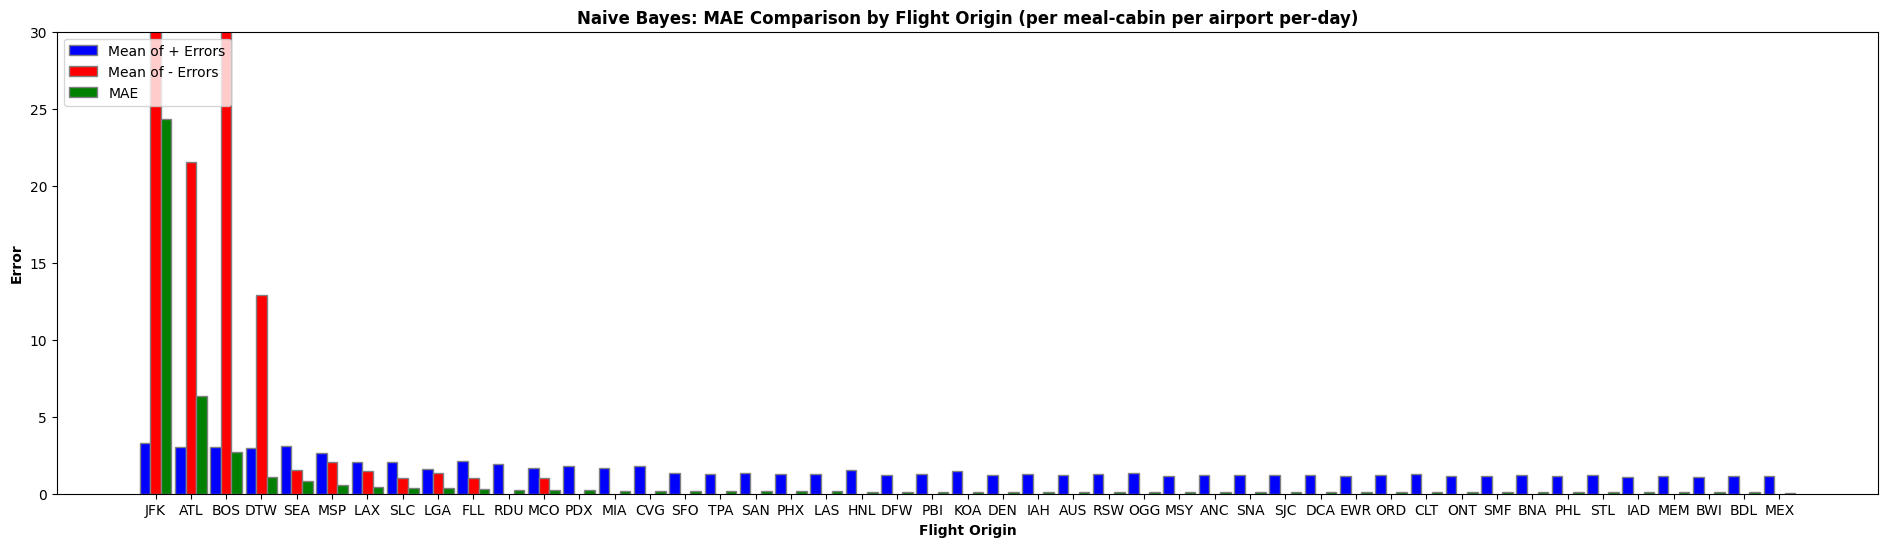

In [64]:
aggregated_df_rf_nb.sort_values(by=['MeanAbsoluteError'], ascending=False, inplace=True)

# Extracting data for plotting
flight_origins = aggregated_df_rf_nb['Airport']
positive_errors = aggregated_df_rf_nb['PositiveError']
negative_errors = aggregated_df_rf_nb['NegativeError']
absolute_differences = aggregated_df_rf_nb['MeanAbsoluteError']

# Setting the width of the bars
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(flight_origins))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the figure wider
plt.figure(figsize=(len(flight_origins) * .5, 6))

# Plotting the bars
plt.bar(r1, positive_errors, color='b', width=bar_width, edgecolor='grey', label='Mean of + Errors')
plt.bar(r2, negative_errors, color='r', width=bar_width, edgecolor='grey', label='Mean of - Errors')
plt.bar(r3, absolute_differences, color='g', width=bar_width, edgecolor='grey', label='MAE')

# Adding labels
plt.xlabel('Flight Origin', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(flight_origins))], flight_origins)
plt.ylabel('Error', fontweight='bold')
plt.title('Naive Bayes: MAE Comparison by Flight Origin (per meal-cabin per airport per-day)', fontweight='bold')

# Adding legend
plt.legend()

plt.ylim(0, 30)

# Show plot
plt.show()

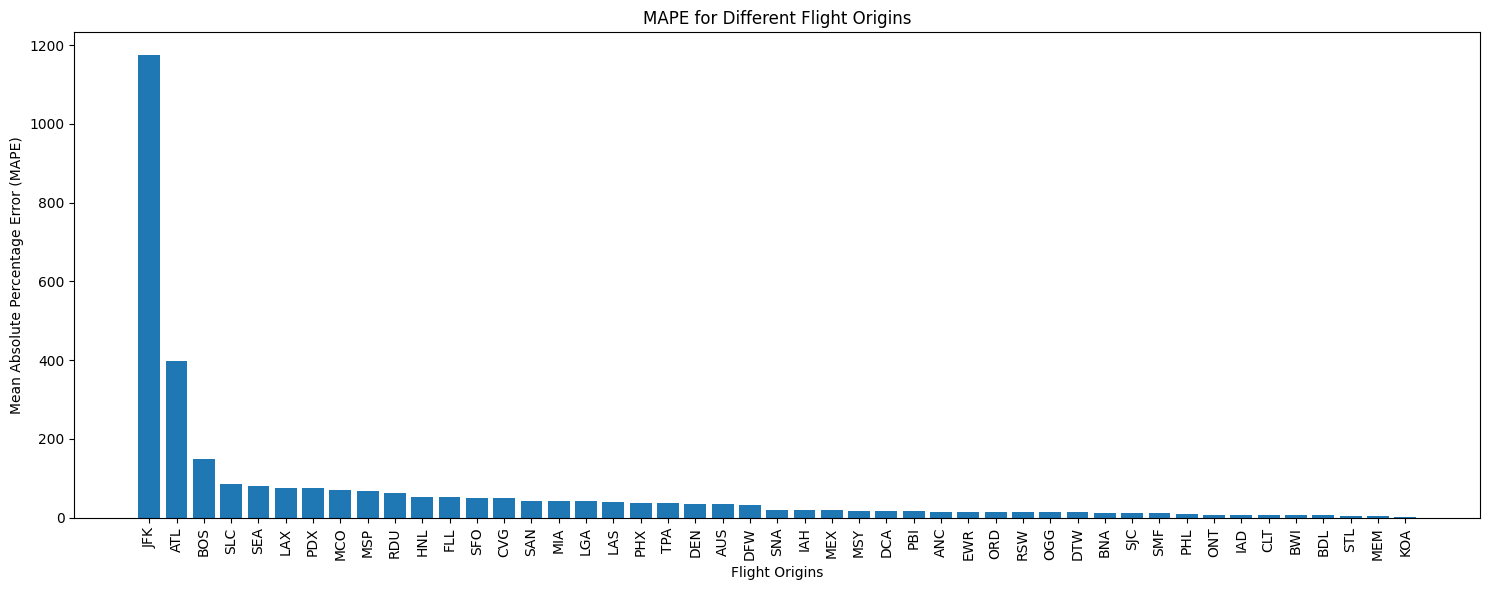

In [65]:
aggregated_df_rf_nb.sort_values(by=['MAPE'], ascending=False, inplace=True)

# Sort the DataFrame by 'MAPE' column
aggregated_df_rf_nb.sort_values(by=['MAPE'], ascending=False, inplace=True)

# Extracting data for plotting
flight_origins = aggregated_df_rf_nb['Airport']
mapes = aggregated_df_rf_nb['MAPE']

# Create the plot
plt.figure(figsize=(15, 6))
plt.bar(flight_origins, mapes)
plt.xlabel('Flight Origins')
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.title('MAPE for Different Flight Origins')
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.show()

### Experiment

In [ ]:
# Initialize a list to store (date, MAPE) tuples
mape_tuples_nb = []

# Get unique FlightDate values
unique_dates = processed_dataset['FlightDate'].unique()

num_dates = 1412
cur_date = 0

# Iterate through each unique date in the dataset
for date in unique_dates:
    # Extract data up to the current date
    data_train = processed_dataset[(processed_dataset['FlightDate'] < date)]
    
    # Check if there is enough data for training (minimum 180 days of data)
    if data_train['FlightDate'].nunique() < 180: 
        continue

    # Make predictions for the next 8 weeks (56 days)
    prediction_end_date = pd.Timestamp(date) + pd.DateOffset(days=56)
    data_test = processed_dataset[(processed_dataset['FlightDate'] > date) & 
                            (processed_dataset['FlightDate'] <= prediction_end_date)]
    
    # Ensure there is 8 weeks of data in the test set
    earliest_date = data_test['FlightDate'].min()
    latest_date = data_test['FlightDate'].max()
    difference_in_weeks = (latest_date - earliest_date).days / 7
    if difference_in_weeks < 7: 
        break
    
    # For now, we only build a new model every Sunday. On other days, we use the most recently created model
    # We have verified that the analysis is similar if you are to compute a new model daily
    if date.day_name() == 'Sunday':
        # Initialize the Naive Bayes model
        naive_bayes_model = GaussianNB()

        # Train the model
        naive_bayes_model.fit(data_train.drop(columns=['TotalCateredQuantity', 'FlightDate'], inplace=False), data_train['TotalCateredQuantity'])

    # Make predictions
    y_pred = np.round(naive_bayes_model.predict(data_test.drop(columns=['TotalCateredQuantity', 'FlightDate'], inplace=False)))
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(data_test['TotalCateredQuantity'], y_pred, 1)
    
    # Store the date and MAPE value
    mape_tuples_nb.append((date, mape))
    
    cur_date += 1
    print(f"\rProgress: {cur_date}/{num_dates} ({cur_date/num_dates*100:.2f}%)", end='', flush=True)

Progress: 1233/1412 (87.32%)

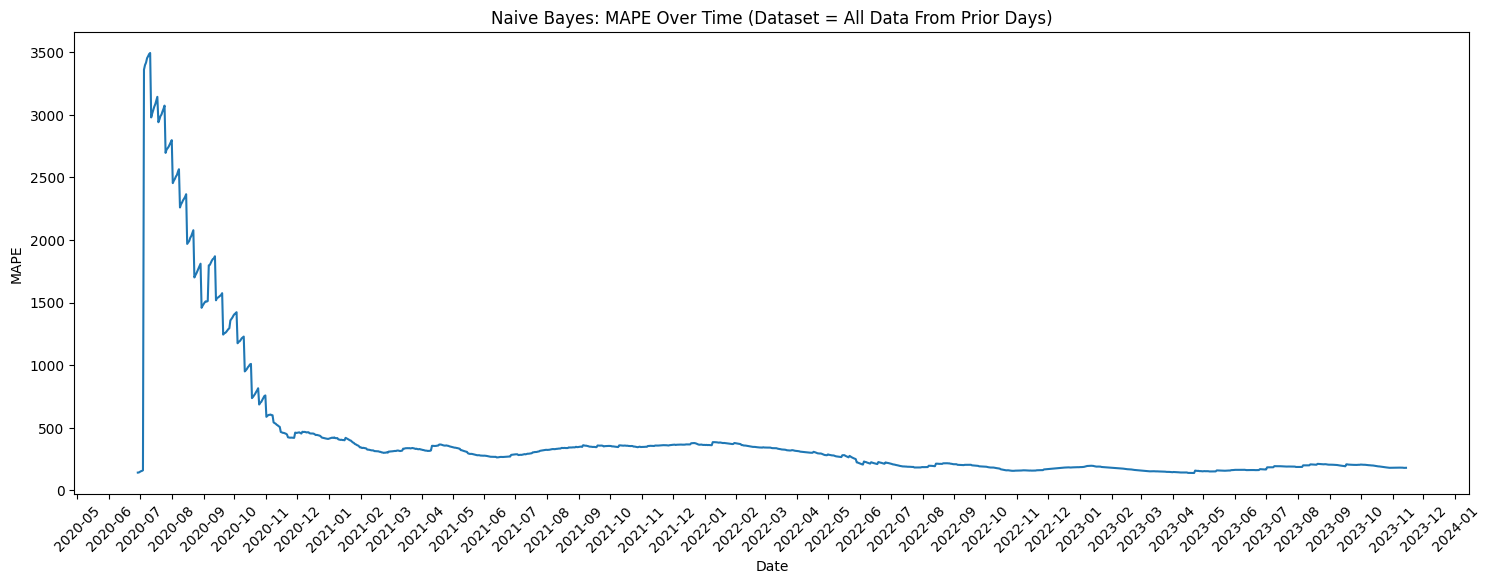

In [ ]:
# Extract dates and MAPE values from the list of tuples
dates_nb = [pair[0] for pair in mape_tuples_nb]
mape_values_nb = [pair[1] for pair in mape_tuples_nb]

# Create a graph to show how the MAPE changed over time
width = 18 
height = 6 
plt.figure(figsize=(width, height))
plt.plot(dates_nb, mape_values_nb)
plt.xlabel('Date')
plt.ylabel('MAPE')
plt.title('Naive Bayes: MAPE Over Time (Dataset = All Data From Prior Days)')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

## RandomForestRegressor

### Normal Model

In [66]:
# Initialize and train RandomForestRegressor
rf_regressor = RandomForestRegressor(n_jobs=-1)
rf_regressor.fit(X_train, y_train)
y_pred_rf = rf_regressor.predict(X_test)

# Round predictions to the nearest whole number
y_pred_rf = np.round(y_pred_rf)

# joblib.dump(rf_regressor, 'random_forest_model.pkl')

In [67]:
# rf_regressor = joblib.load('random_forest_model.pkl')

# Evaluate RandomForestRegressor
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf, 1)

print("Random Forest Regressor - Row Level Metrics:")
print("Mean Squared Error:", mse_rf)
print("Mean Absolute Error:", mae_rf)
print("Mean Absolute Percentage Error:", str(round(mape_rf, 2)) + '%')
print("R-squared:", r2_rf)

Random Forest Regressor - Row Level Metrics:
Mean Squared Error: 3.769088197568445
Mean Absolute Error: 0.4817510632682996
Mean Absolute Percentage Error: 18.4%
R-squared: 0.7224358788711585


In [68]:
# Access feature importances
feature_importances = rf_regressor.feature_importances_

feature_names = X_train.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("RandomForest Feature Importance:")
print(feature_importance_df)

RandomForest Feature Importance:
                                 Feature  Importance
1                               MealCode    0.252393
9                           DayOfTheWeek    0.117970
2                              CabinCode    0.083747
3                         OriginLatitude    0.060053
0                           FlightOrigin    0.059874
4                        OriginLongitude    0.055763
18                         TotalCapacity    0.055342
20                    TotalInternational    0.055075
11                        DistFromPesach    0.053622
17                         TotalDistance    0.052329
10  DistFromChineseNewYearSpringFestival    0.050122
7                                    Day    0.046544
8                             WeekOfYear    0.023687
16                            NumFlights    0.011630
5                                   Year    0.010507
6                                  Month    0.007888
19                         TotalDomestic    0.001797
15           

### Aggregated Output

In [69]:
gc.collect()

# Make predictions on the validation set
y_val_pred_rf = np.round(rf_regressor.predict(X_val))

# Create a DataFrame to store the results more neatly
results_df_rf = pd.DataFrame({
    'FlightDate': pd.to_datetime(X_val_decoded[['Year', 'Month', 'Day']]),
    'FlightOrigin': X_val_decoded['FlightOrigin'],
    'CabinCode': X_val_decoded['CabinCode'],
    'MealCode': X_val_decoded['MealCode'],
    'ActualQuantity': y_val,
    'PredictedQuantity': y_val_pred_rf
})

# Calculate absolute difference per row
results_df_rf['AbsoluteDifference'] = abs(results_df_rf['ActualQuantity'] - results_df_rf['PredictedQuantity'])
results_df_rf['Error'] = results_df_rf['ActualQuantity'] - results_df_rf['PredictedQuantity']

print("RandomForestRegressor Aggregated Results:")

# Calculate total absolute error per airport per day
airport_error_rf = results_df_rf.groupby(['FlightOrigin', 'FlightDate'], as_index=False, observed=True).agg({'AbsoluteDifference': 'sum', 'ActualQuantity': 'sum', 'PredictedQuantity': 'sum'})
airport_error_rf['Error'] = airport_error_rf['ActualQuantity'] - airport_error_rf['PredictedQuantity']
airport_mae_rf = airport_error_rf['AbsoluteDifference'].mean()
airport_mape_rf = mean_absolute_percentage_error(airport_error_rf['ActualQuantity'], airport_error_rf['PredictedQuantity'], 1e3)
print("\nMAE per airport per day:", round(airport_mae_rf, 2))
print("MAPE per airport per day:", str(round(airport_mape_rf, 2)) + "%")

# Calculate total absolute error across all flights on each day
day_error_rf = results_df_rf.groupby('FlightDate').agg({'AbsoluteDifference': 'sum', 'ActualQuantity': 'sum', 'PredictedQuantity': 'sum'})
day_mae_rf = day_error_rf['AbsoluteDifference'].mean()
day_mape_rf = mean_absolute_percentage_error(day_error_rf['ActualQuantity'], day_error_rf['PredictedQuantity'], 1e3)
print("\nMAE per full day (across all airports):", round(day_mae_rf, 2))
print("MAPE per full day (across all airports):", str(round(day_mape_rf, 2)) + "%")

RandomForestRegressor Aggregated Results:

MAE per airport per day: 27.48
MAPE per airport per day: 0.74%

MAE per full day (across all airports): 931.51
MAPE per full day (across all airports): 8.8%


### Error Analysis

In [70]:
results_df_rf['PositiveError'] = results_df_rf['Error'].apply(lambda x: x if x > 0 else None)
results_df_rf['NegativeError'] = results_df_rf['Error'].apply(lambda x: x if x < 0 else None)
results_df_rf['NegativeError'] = results_df_rf['NegativeError'].abs()

# Create new columns based on conditions
results_df_rf['IsPos'] = (results_df_rf['Error'] > 0).astype(int)
results_df_rf['IsNeg'] = (results_df_rf['Error'] < 0).astype(int)

aggregated_df_rf = results_df_rf.groupby('FlightOrigin', observed=True).agg({
    'AbsoluteDifference': 'mean',
    'ActualQuantity': 'sum', 
    'PredictedQuantity': 'sum',
    'PositiveError': 'mean',
    'NegativeError': 'mean',
    'IsPos': 'sum',
    'IsNeg': 'sum'
}).reset_index()

aggregated_df_rf['MAPE'] = aggregated_df_rf.apply(lambda row: mean_absolute_percentage_error(row['ActualQuantity'], row['PredictedQuantity'], 1e3), axis=1)

aggregated_df_rf['PercentPositive'] = aggregated_df_rf['IsPos'] / (aggregated_df_rf['IsPos'] + aggregated_df_rf['IsNeg'])
aggregated_df_rf['PercentNegative'] = aggregated_df_rf['IsNeg'] / (aggregated_df_rf['IsPos'] + aggregated_df_rf['IsNeg'])

aggregated_df_rf.sort_values(by=['PercentPositive', 'FlightOrigin'], inplace=True)

aggregated_df_rf['PercentPositive'] = (aggregated_df_rf['PercentPositive'] * 100).round(2).astype(str) + '%'
aggregated_df_rf['PercentNegative'] = (aggregated_df_rf['PercentNegative'] * 100).round(2).astype(str) + '%'

aggregated_df_rf = aggregated_df_rf.rename(columns={'AbsoluteDifference': 'MeanAbsoluteError', 'FlightOrigin': 'Airport'})

# Print markdown table
print("RandomForest: Occurences of meals in cabins where error is positive vs. negative at each Origin")
print(aggregated_df_rf[['Airport', 'MeanAbsoluteError', 'PercentPositive', 'PercentNegative']].to_markdown(index=False))

RandomForest: Occurences of meals in cabins where error is positive vs. negative at each Origin
| Airport   |   MeanAbsoluteError | PercentPositive   | PercentNegative   |
|:----------|--------------------:|:------------------|:------------------|
| BOS       |           0.75971   | 36.3%             | 63.7%             |
| HNL       |           0.212165  | 38.29%            | 61.71%            |
| JFK       |           1.27394   | 38.64%            | 61.36%            |
| ATL       |           0.811227  | 40.52%            | 59.48%            |
| DTW       |           0.476407  | 41.68%            | 58.32%            |
| LAX       |           0.474648  | 42.18%            | 57.82%            |
| SEA       |           0.566918  | 42.23%            | 57.77%            |
| OGG       |           0.158964  | 42.56%            | 57.44%            |
| MSP       |           0.418658  | 44.6%             | 55.4%             |
| SLC       |           0.343537  | 44.62%            | 55.38%      

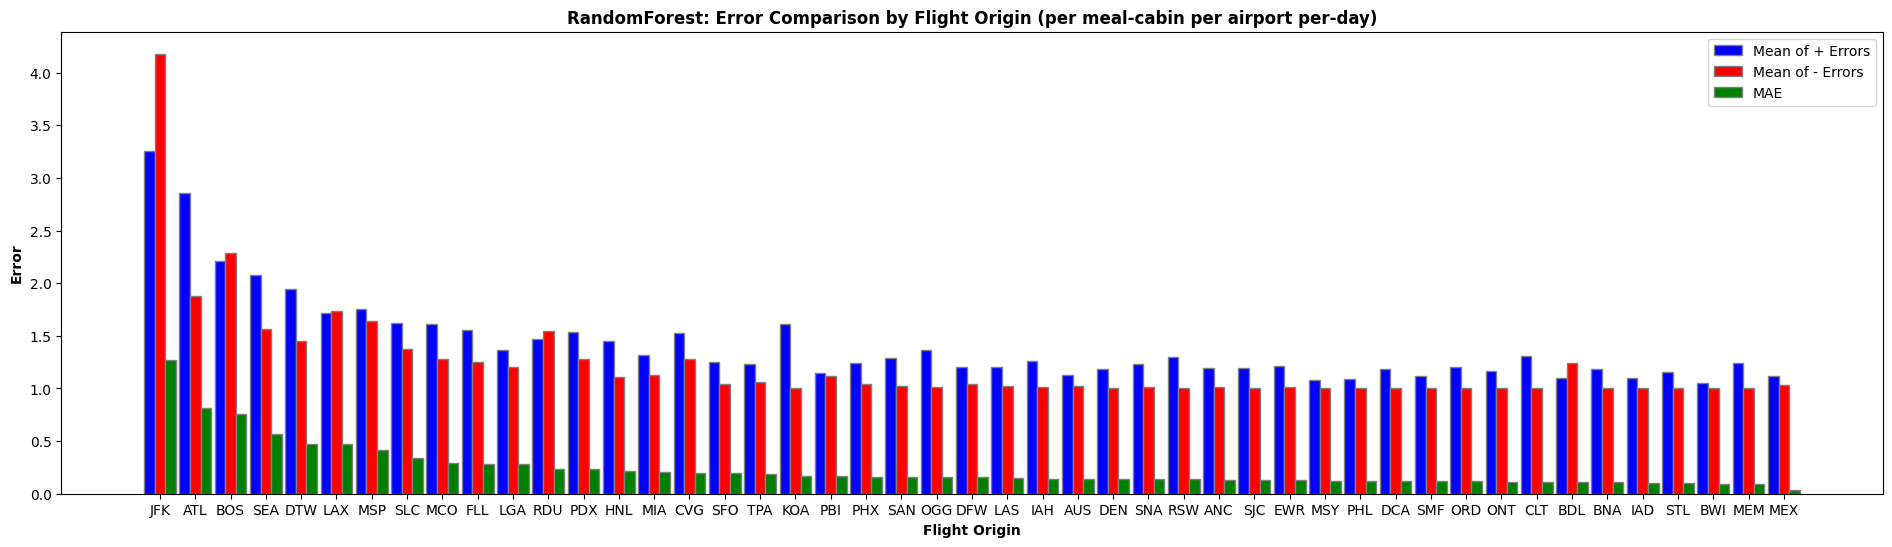

In [71]:
aggregated_df_rf.sort_values(by=['MeanAbsoluteError'], ascending=False, inplace=True)

# Extracting data for plotting
flight_origins = aggregated_df_rf['Airport']
positive_errors = aggregated_df_rf['PositiveError']
negative_errors = aggregated_df_rf['NegativeError']
absolute_differences = aggregated_df_rf['MeanAbsoluteError']

# Setting the width of the bars
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(flight_origins))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the figure wider
plt.figure(figsize=(len(flight_origins) * .5, 6))

# Plotting the bars
plt.bar(r1, positive_errors, color='b', width=bar_width, edgecolor='grey', label='Mean of + Errors')
plt.bar(r2, negative_errors, color='r', width=bar_width, edgecolor='grey', label='Mean of - Errors')
plt.bar(r3, absolute_differences, color='g', width=bar_width, edgecolor='grey', label='MAE')

# Adding labels
plt.xlabel('Flight Origin', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(flight_origins))], flight_origins)
plt.ylabel('Error', fontweight='bold')
plt.title('RandomForest: Error Comparison by Flight Origin (per meal-cabin per airport per-day)', fontweight='bold')

# Adding legend
plt.legend()

# Show plot
plt.show()

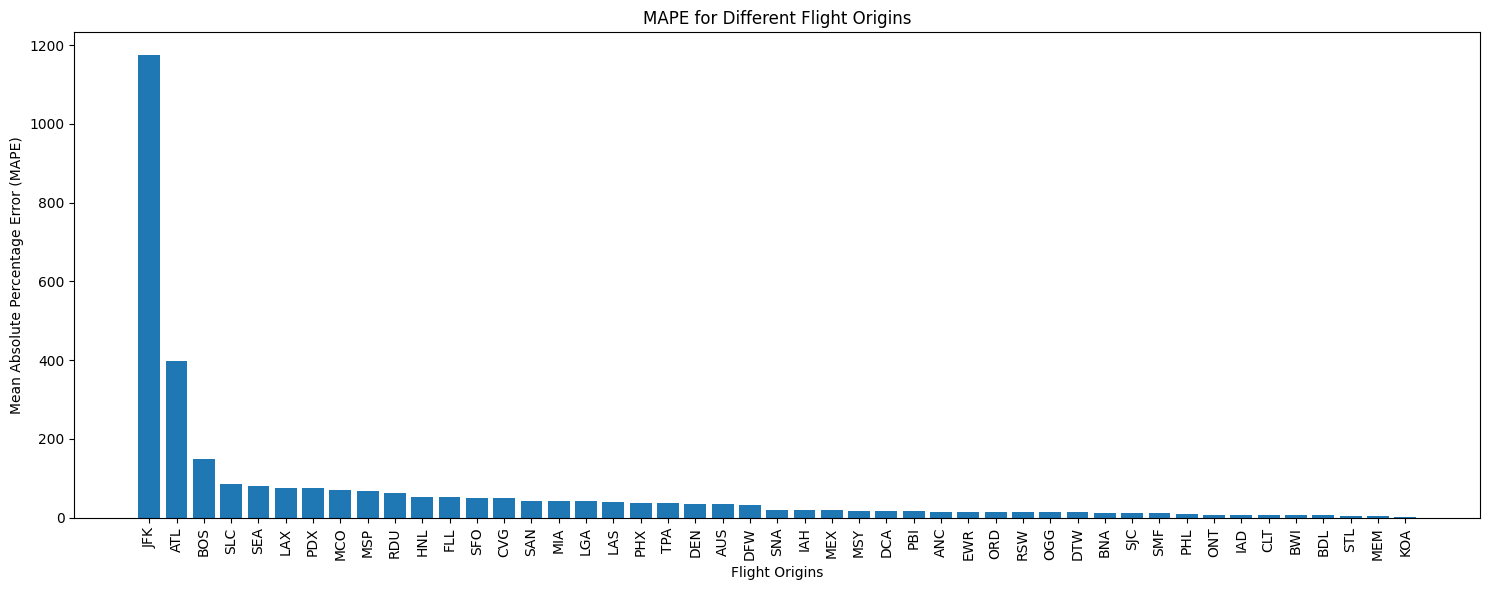

In [72]:
aggregated_df_rf_nb.sort_values(by=['MAPE'], ascending=False, inplace=True)

# Extracting data for plotting
flight_origins = aggregated_df_rf_nb['Airport']
mapes = aggregated_df_rf_nb['MAPE']

# Sort the DataFrame by 'MAPE' column
aggregated_df_rf_nb.sort_values(by=['MAPE'], ascending=False, inplace=True)

# Extracting data for plotting
flight_origins = aggregated_df_rf_nb['Airport']
mapes = aggregated_df_rf_nb['MAPE']

# Create the plot
plt.figure(figsize=(15, 6))
plt.bar(flight_origins, mapes)
plt.xlabel('Flight Origins')
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.title('MAPE for Different Flight Origins')
plt.xticks(rotation=90)
plt.tight_layout() 
plt.show()

### EDA

In [73]:
y_val_pred_rf = np.round(rf_regressor.predict(X_val))

eda_df = X_val.copy()

# Add y_val as a new column
eda_df['Actual'] = y_val

# Add y_val_pred_lgb as a new column
eda_df['Predicted'] = y_val_pred_rf

# compute absolute percent error for each row
eda_df['PercentError'] = eda_df.apply(lambda row: mean_absolute_percentage_error(row['Actual'], row['Predicted'], 1), axis=1)

# Calculate correlations between each feature and the MAPE column
correlations = eda_df.drop(columns=['Predicted']).corr()['PercentError'].sort_values(ascending=False)

# Print correlations in descending order
print('RandomForest: Which feautres are associated with high errors?')
print(correlations)

RandomForest: Which feautres are associated with high errors?
PercentError                            1.000000
TotalDistance                           0.168210
TotalCapacity                           0.167451
NumFlights                              0.163794
TotalInternational                      0.156163
CabinCode                               0.120815
1stServiceMeal                          0.101131
PreArrivalMeal                          0.101131
IsHub                                   0.087767
TimeOfDay                               0.074199
Actual                                  0.049554
MidflightMeal                           0.039241
MealCode                                0.037885
OriginLongitude                         0.032743
OriginLatitude                          0.031627
Year                                    0.013356
Month                                   0.009534
WeekOfYear                              0.009137
DistFromPesach                          0.008338
DistFro

### Experiment

In [47]:
# Initialize a list to store (date, MAPE) tuples
mape_tuples_rf = []

# Get unique FlightDate values
unique_dates = processed_dataset['FlightDate'].unique()

num_dates = len(unique_dates) - 56 - 180
cur_date = 0

# Iterate through each unique date in the dataset
for date in unique_dates:
    # Extract data up to the current date
    data_train = processed_dataset[processed_dataset['FlightDate'] <= date]
    
    # Check if there is enough data for training (minimum 180 days of data)
    if data_train['FlightDate'].nunique() < 180: 
        continue

    # Make predictions for the next 8 weeks (56 days)
    prediction_end_date = pd.Timestamp(date) + pd.DateOffset(days=56)
    data_test = processed_dataset[(processed_dataset['FlightDate'] > date) & 
                            (processed_dataset['FlightDate'] <= prediction_end_date)]
    
    # Ensure there is 8 weeks of data in the test set
    earliest_date = data_test['FlightDate'].min()
    latest_date = data_test['FlightDate'].max()
    difference_in_weeks = (latest_date - earliest_date).days / 7
    if difference_in_weeks < 7: 
        break
    
    # Fit a new model every Sunday
    # On all other days, use the most recently fit model
    if date.day_name() == 'Sunday':
        rf_regressor = RandomForestRegressor(n_jobs=-1)
        rf_regressor.fit(data_train.drop(columns=['TotalCateredQuantity', 'FlightDate'], inplace=False), data_train['TotalCateredQuantity'])
    
    # Make predictions    
    y_pred = np.round(rf_regressor.predict(data_test.drop(columns=['TotalCateredQuantity', 'FlightDate'], inplace=False)))

    # Calculate MAPE
    mape = mean_absolute_percentage_error(data_test['TotalCateredQuantity'], y_pred, 1)
    
    # Store the date and MAPE value
    mape_tuples_rf.append((date, mape))
    
    cur_date += 1
    print(f"\rProgress: {cur_date}/{num_dates} ({cur_date/num_dates*100:.2f}%)", end='', flush=True)

Progress: 1234/1226 (100.65%)

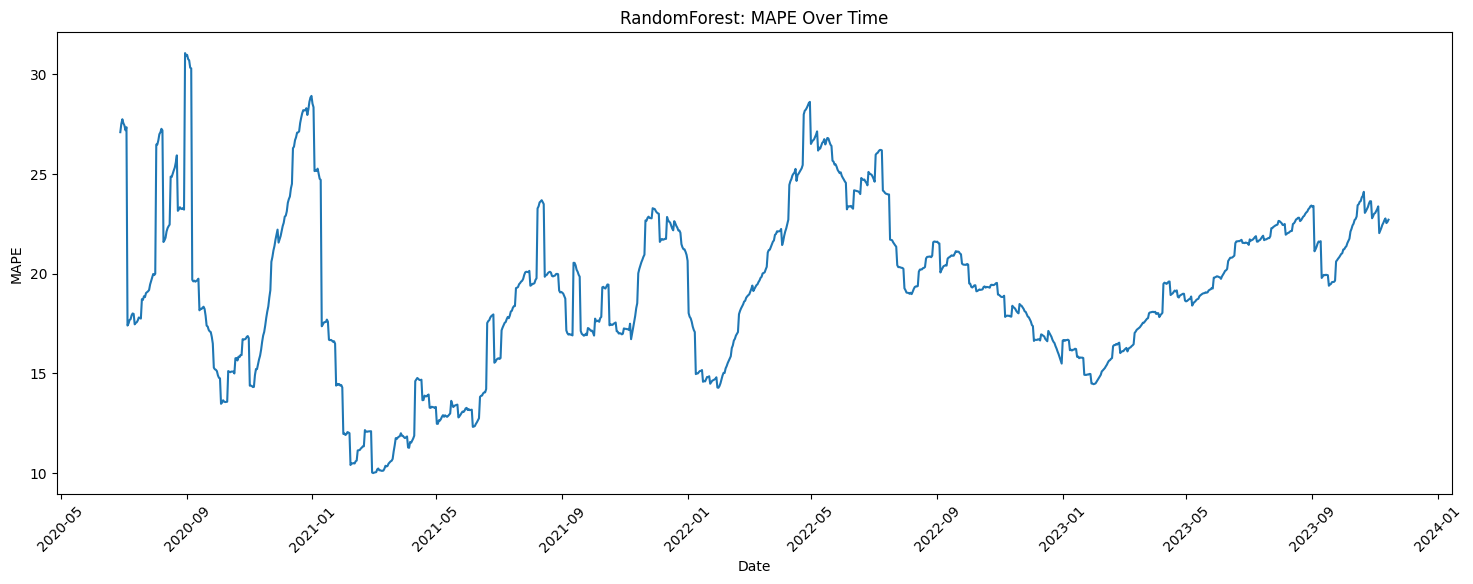

In [48]:
# Extract dates and MAPE values from the list of tuples
dates_rf = [pair[0] for pair in mape_tuples_rf]
mape_values_rf = [pair[1] for pair in mape_tuples_rf]

# Create a graph to show how the MAPE changed over time
width = 18 
height = 6 
plt.figure(figsize=(width, height))
plt.plot(dates_rf, mape_values_rf)
plt.xlabel('Date')
plt.ylabel('MAPE')
plt.title('RandomForest: MAPE Over Time')
plt.xticks(rotation=45)
plt.show()

## LGBM

### Model

In [74]:
best_lgb_model = lgb.LGBMRegressor(verbosity=-1)
best_lgb_model.fit(X_train, y_train)

LGBMRegressor(verbosity=-1)

In [75]:
# Make predictions on the validation set using the best model
y_test_pred_lgb = np.round(best_lgb_model.predict(X_test))

# Evaluate LightGBM model
mse_lgb = mean_squared_error(y_test, y_test_pred_lgb)
mae_lgb = mean_absolute_error(y_test, y_test_pred_lgb)
r2_lgb = r2_score(y_test, y_test_pred_lgb)
mape_lgb = mean_absolute_percentage_error(y_test, y_test_pred_lgb, 1)

print("LightGBM Regressor:")
print("Mean Squared Error:", mse_lgb)
print("Mean Absolute Error:", mae_lgb)
print("Mean Absolute Percentage Error:", str(round(mape_lgb, 2)) + '%')
print("R-squared:", r2_lgb)

LightGBM Regressor:
Mean Squared Error: 4.176204883976409
Mean Absolute Error: 0.48641532824764794
Mean Absolute Percentage Error: 16.41%
R-squared: 0.692454891604102


In [76]:
feature_importances = best_lgb_model.feature_importances_

feature_names = X_train.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print('LightGBM - Feature Importance:')
print(feature_importance_df)

LightGBM - Feature Importance:
                                 Feature  Importance
1                               MealCode         782
2                              CabinCode         304
10  DistFromChineseNewYearSpringFestival         262
17                         TotalDistance         221
11                        DistFromPesach         207
9                           DayOfTheWeek         198
18                         TotalCapacity         190
5                                   Year         140
0                           FlightOrigin         119
7                                    Day         116
16                            NumFlights          96
4                        OriginLongitude          84
3                         OriginLatitude          69
8                             WeekOfYear          65
19                         TotalDomestic          53
20                    TotalInternational          32
6                                  Month          28
15             

### Aggregated Results

In [77]:
gc.collect()

# Make predictions on the validation set
y_val_pred_lgb = np.round(best_lgb_model.predict(X_val))

# Create a DataFrame to store the results more neatly
results_df_lgb = pd.DataFrame({
    'FlightDate': pd.to_datetime(X_val_decoded[['Year', 'Month', 'Day']]),
    'FlightOrigin': X_val_decoded['FlightOrigin'],
    'CabinCode': X_val_decoded['CabinCode'],
    'MealCode': X_val_decoded['MealCode'],
    'ActualQuantity': y_val,
    'PredictedQuantity': y_val_pred_lgb
})

# Calculate absolute difference per row
results_df_lgb['AbsoluteDifference'] = abs(results_df_lgb['ActualQuantity'] - results_df_lgb['PredictedQuantity'])
results_df_lgb['Error'] = results_df_lgb['PredictedQuantity'] - results_df_lgb['ActualQuantity']

print("LightGBM Aggregated Results:")

# Calculate total absolute error per airport per day
airport_error_lgb = results_df_lgb.groupby(['FlightOrigin', 'FlightDate'], as_index=False, observed=True).agg({'AbsoluteDifference': 'sum', 'ActualQuantity': 'sum', 'PredictedQuantity': 'sum'})
airport_error_lgb['Error'] = airport_error_lgb['ActualQuantity'] - airport_error_lgb['PredictedQuantity']
airport_mae_lgb = airport_error_lgb['AbsoluteDifference'].mean()
airport_mape_lgb = mean_absolute_percentage_error(airport_error_lgb['ActualQuantity'], airport_error_lgb['PredictedQuantity'], 1e3)
print("\nMAE per airport per day:", round(airport_mae_lgb, 2))
print("MAPE per airport per day:", str(round(airport_mape_lgb, 2)) + "%")

# Calculate total absolute error across all flights on each day
day_error_lgb = results_df_lgb.groupby('FlightDate').agg({'AbsoluteDifference': 'sum', 'ActualQuantity': 'sum', 'PredictedQuantity': 'sum'})
day_mae_lgb = day_error_lgb['AbsoluteDifference'].mean()
day_mape_lgb = mean_absolute_percentage_error(day_error_lgb['ActualQuantity'], day_error_lgb['PredictedQuantity'], 1e3)
print("\nMAE per full day (across all airports):", round(day_mae_lgb, 2))
print("MAPE per full day (across all airports):", str(round(day_mape_lgb, 2)) + "%")

LightGBM Aggregated Results:

MAE per airport per day: 25.61
MAPE per airport per day: 0.83%

MAE per full day (across all airports): 868.16
MAPE per full day (across all airports): 8.18%


### Error Analysis

In [78]:
results_df_lgb['PositiveError'] = results_df_lgb['Error'].apply(lambda x: x if x > 0 else None)
results_df_lgb['NegativeError'] = results_df_lgb['Error'].apply(lambda x: x if x < 0 else None)
results_df_lgb['NegativeError'] = results_df_lgb['NegativeError'].abs()

# Create new columns based on conditions
results_df_lgb['IsPos'] = (results_df_lgb['Error'] > 0).astype(int)
results_df_lgb['IsNeg'] = (results_df_lgb['Error'] < 0).astype(int)

aggregated_df_rf_lgb = results_df_lgb.groupby('FlightOrigin', observed=True).agg({
    'AbsoluteDifference': 'mean',
    'ActualQuantity': 'sum', 
    'PredictedQuantity': 'sum',
    'PositiveError': 'mean',
    'NegativeError': 'mean',
    'IsPos': 'sum',
    'IsNeg': 'sum'
}).reset_index()

aggregated_df_rf_lgb['MAPE'] = aggregated_df_rf_lgb.apply(lambda row: mean_absolute_percentage_error(row['ActualQuantity'], row['PredictedQuantity'], 1e3), axis=1)

aggregated_df_rf_lgb['PercentPositive'] = aggregated_df_rf_lgb['IsPos'] / (aggregated_df_rf_lgb['IsPos'] + aggregated_df_rf_lgb['IsNeg'])
aggregated_df_rf_lgb['PercentNegative'] = aggregated_df_rf_lgb['IsNeg'] / (aggregated_df_rf_lgb['IsPos'] + aggregated_df_rf_lgb['IsNeg'])

aggregated_df_rf_lgb.sort_values(by=['PercentPositive', 'FlightOrigin'], inplace=True)

aggregated_df_rf_lgb['PercentPositive'] = (aggregated_df_rf_lgb['PercentPositive'] * 100).round(2).astype(str) + '%'
aggregated_df_rf_lgb['PercentNegative'] = (aggregated_df_rf_lgb['PercentNegative'] * 100).round(2).astype(str) + '%'

aggregated_df_rf_lgb = aggregated_df_rf_lgb.rename(columns={'AbsoluteDifference': 'MeanAbsoluteError', 'FlightOrigin': 'Airport'})

# Print markdown table
print("LightGBM: Occurrences of meals in cabins where error is positive vs. negative at each Origin")
print(aggregated_df_rf_lgb[['Airport', 'MeanAbsoluteError', 'PercentPositive', 'PercentNegative']].to_markdown(index=False))

LightGBM: Occurrences of meals in cabins where error is positive vs. negative at each Origin
| Airport   |   MeanAbsoluteError | PercentPositive   | PercentNegative   |
|:----------|--------------------:|:------------------|:------------------|
| IAD       |           0.0857143 | 0.0%              | 100.0%            |
| KOA       |           0.131868  | 0.0%              | 100.0%            |
| MEM       |           0.0841837 | 0.0%              | 100.0%            |
| STL       |           0.0901361 | 0.0%              | 100.0%            |
| BNA       |           0.0950069 | 0.88%             | 99.12%            |
| BDL       |           0.0829082 | 3.33%             | 96.67%            |
| ONT       |           0.1       | 4.11%             | 95.89%            |
| ORD       |           0.105006  | 5.56%             | 94.44%            |
| DCA       |           0.104144  | 6.71%             | 93.29%            |
| SJC       |           0.106331  | 7.14%             | 92.86%         

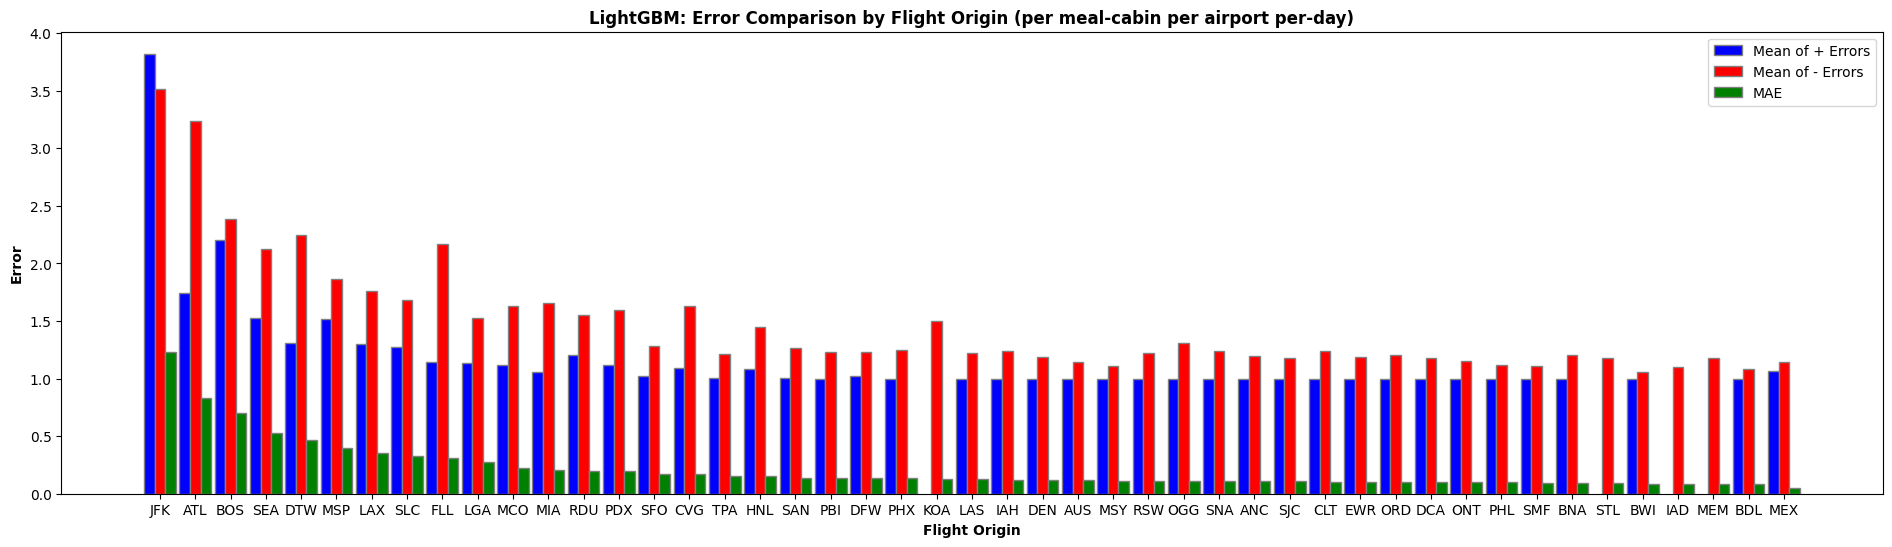

In [79]:
aggregated_df_rf_lgb.sort_values(by=['MeanAbsoluteError'], ascending=False, inplace=True)

# Extracting data for plotting
flight_origins_lgb = aggregated_df_rf_lgb['Airport']
positive_errors_lgb = aggregated_df_rf_lgb['PositiveError']
negative_errors_lgb = aggregated_df_rf_lgb['NegativeError']
absolute_differences_lgb = aggregated_df_rf_lgb['MeanAbsoluteError']

# Setting the width of the bars
bar_width = 0.3

# Set position of bar on X axis
r1 = np.arange(len(flight_origins_lgb))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the figure wider
plt.figure(figsize=(len(flight_origins_lgb) * .5, 6))

# Plotting the bars
plt.bar(r1, positive_errors_lgb, color='b', width=bar_width, edgecolor='grey', label='Mean of + Errors')
plt.bar(r2, negative_errors_lgb, color='r', width=bar_width, edgecolor='grey', label='Mean of - Errors')
plt.bar(r3, absolute_differences_lgb, color='g', width=bar_width, edgecolor='grey', label='MAE')

# Adding labels
plt.xlabel('Flight Origin', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(flight_origins_lgb))], flight_origins_lgb)
plt.ylabel('Error', fontweight='bold')
plt.title('LightGBM: Error Comparison by Flight Origin (per meal-cabin per airport per-day)', fontweight='bold')

# Adding legend
plt.legend()

# Show plot
plt.show()

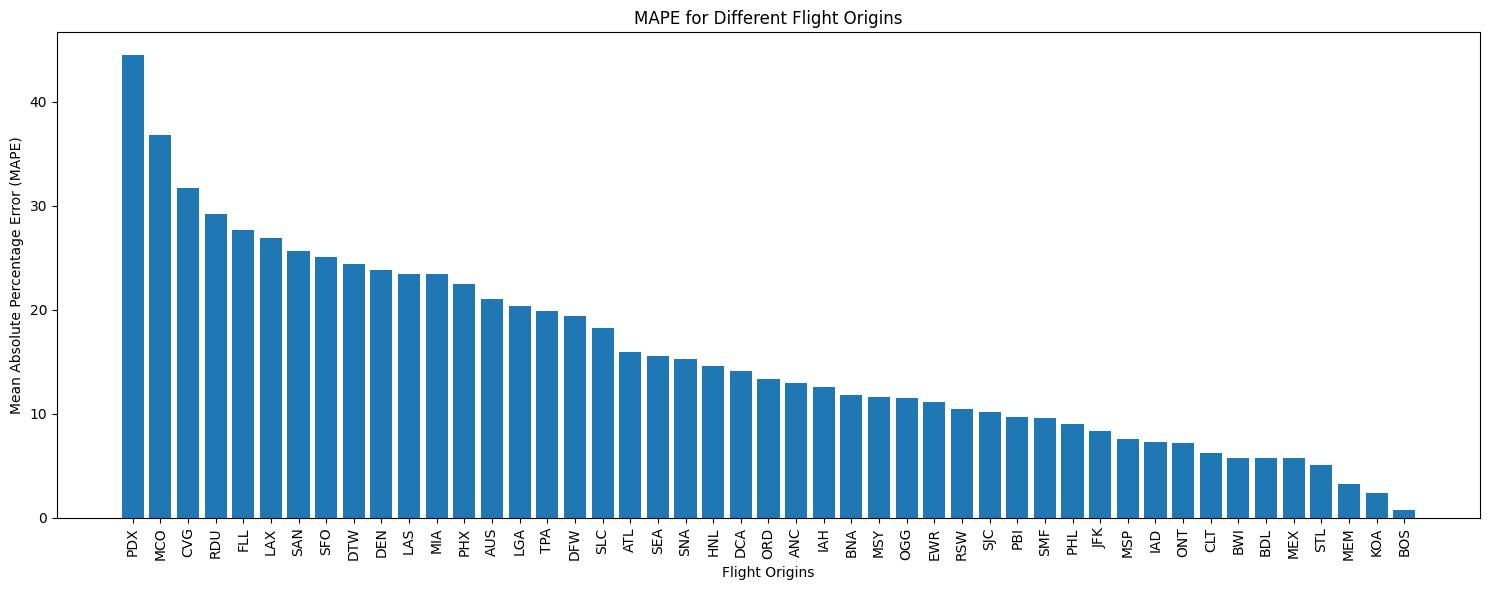

In [80]:
# Sort the DataFrame by 'MAPE' column
aggregated_df_rf_lgb.sort_values(by=['MAPE'], ascending=False, inplace=True)

# Extracting data for plotting
flight_origins = aggregated_df_rf_lgb['Airport']
mapes = aggregated_df_rf_lgb['MAPE']

# Create the plot
plt.figure(figsize=(15, 6))
plt.bar(flight_origins, mapes)
plt.xlabel('Flight Origins')
plt.ylabel('Mean Absolute Percentage Error (MAPE)')
plt.title('MAPE for Different Flight Origins')
plt.xticks(rotation=90)
plt.tight_layout()  
plt.show()

### EDA

In [81]:
y_val_pred_lgb = np.round(best_lgb_model.predict(X_val))

eda_df = X_val.copy()

# Add y_val as a new column
eda_df['Actual'] = y_val

# Add y_val_pred_lgb as a new column
eda_df['Predicted'] = y_val_pred_lgb

eda_df['PercentError'] = eda_df.apply(lambda row: mean_absolute_percentage_error(row['Actual'], row['Predicted'], 1), axis=1)

# Calculate correlations between each feature and the MAPE column
correlations = eda_df.drop(columns=['Predicted']).corr()['PercentError'].sort_values(ascending=False)

# Print correlations in descending order
print('LIghtGBM: Which features are associated with high errors?')
print(correlations)

LIghtGBM: Which features are associated with high errors?
PercentError                            1.000000
TotalCapacity                           0.277392
TotalDistance                           0.274555
NumFlights                              0.273158
TotalInternational                      0.262261
CabinCode                               0.195872
1stServiceMeal                          0.139557
PreArrivalMeal                          0.139557
IsHub                                   0.135049
Actual                                  0.105690
TimeOfDay                               0.102075
OriginLongitude                         0.074027
OriginLatitude                          0.059808
MealCode                                0.058387
MidflightMeal                           0.011637
TotalDomestic                           0.007399
DistFromChineseNewYearSpringFestival    0.004368
DistFromPesach                          0.004364
WeekOfYear                              0.004284
Month      

### Experiment

In [58]:
# Initialize a list to store (date, MAPE) tuples
mape_tuples_lgbm = []

# Get unique FlightDate values
unique_dates = processed_dataset['FlightDate'].unique()

num_dates = len(unique_dates) - 56 - 180
cur_date = 0

# Iterate through each unique date in the dataset
for date in unique_dates:
    # Extract data up to the current date
    data_train = processed_dataset[(processed_dataset['FlightDate'] < date)]
    
    # Check if there is enough data for training (minimum 180 days of data)
    if data_train['FlightDate'].nunique() < 180: 
        continue

    # Make predictions for the next 8 weeks (56 days)
    prediction_end_date = pd.Timestamp(date) + pd.DateOffset(days=56)
    data_test = processed_dataset[(processed_dataset['FlightDate'] > date) & 
                            (processed_dataset['FlightDate'] <= prediction_end_date)]
    
    # Ensure there is 8 weeks of data in the test set
    earliest_date = data_test['FlightDate'].min()
    latest_date = data_test['FlightDate'].max()
    difference_in_weeks = (latest_date - earliest_date).days / 7
    if difference_in_weeks < 7: 
        break
    
    # Fit a new model on Sundays
    # On all other days, use the most recently fit model
    if date.day_name() == 'Monday':
        # Build LGBM model
        lgb_model = lgb.LGBMRegressor(verbosity=-1)
        lgb_model.fit(data_train.drop(columns=['TotalCateredQuantity', 'FlightDate'], inplace=False), data_train['TotalCateredQuantity'])
    
    # Make predictions
    y_pred = np.round(lgb_model.predict(data_test.drop(columns=['TotalCateredQuantity', 'FlightDate'], inplace=False)))
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(data_test['TotalCateredQuantity'], y_pred, 1)
    
    # Store the date and MAPE value
    mape_tuples_lgbm.append((date, mape))
    
    cur_date += 1
    print(f"\rProgress: {cur_date}/{num_dates} ({cur_date/num_dates*100:.2f}%)", end='', flush=True)

Progress: 1233/1226 (100.57%)

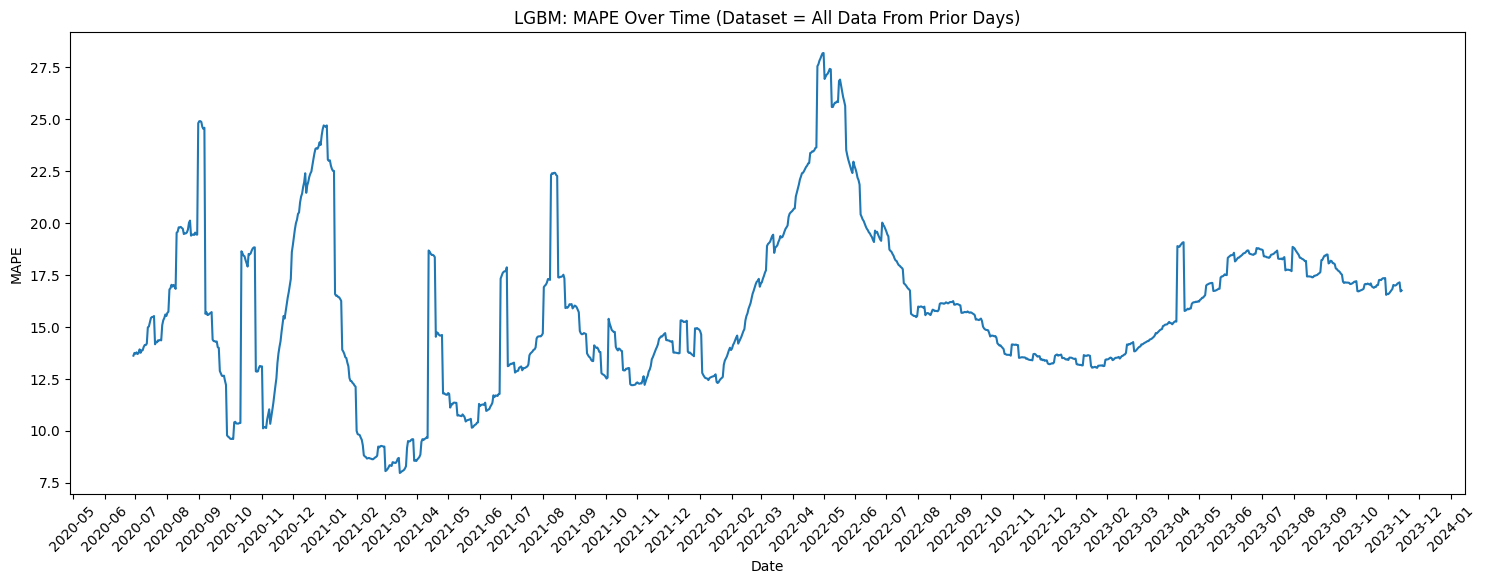

In [59]:
# Extract dates and MAPE values from the list of tuples
dates_lgbm = [pair[0] for pair in mape_tuples_lgbm]
mape_values_lgbm = [pair[1] for pair in mape_tuples_lgbm]


# Create a graph to show how the MAPE changed over time
width = 18  # Adjust this value as needed
height = 6  # Adjust this value as needed
plt.figure(figsize=(width, height))
plt.plot(dates_lgbm, mape_values_lgbm)
plt.xlabel('Date')
plt.ylabel('MAPE')
plt.title('LGBM: MAPE Over Time (Dataset = All Data From Prior Days)')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())
plt.xticks(rotation=45)
plt.show()

## k-NN

### Model

In [82]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Set the parameter grid for hyperparameter tuning
param_grid = {
    'n_neighbors': [3, 5, 7]  # Example values for n_neighbors
}

# Initialize KNeighborsRegressor
knn_regressor = KNeighborsRegressor(weights='distance', metric='manhattan')

# Initialize TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform grid search with time series cross-validation
grid_search = GridSearchCV(estimator=knn_regressor, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model from the grid search
best_knn_regressor = grid_search.best_estimator_

# Fit the best model on the entire training data
best_knn_regressor.fit(X_train_scaled, y_train)

# Store the best model as knn_regressor
knn_regressor = best_knn_regressor

In [83]:
print(grid_search.best_params_)

{'n_neighbors': 5}


In [84]:
y_pred_knn = best_knn_regressor.predict(X_test_scaled)

# Round predictions to the nearest whole number
y_pred_knn = np.round(y_pred_knn)

# Evaluate kNN Regressor
mse_knn = mean_squared_error(y_test, y_pred_knn)
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
mape_knn = mean_absolute_percentage_error(y_test, y_pred_knn, 1)

print("kNN - Row Level Metrics:")
print("Mean Squared Error:", mse_knn)
print("Mean Absolute Error:", mae_knn)
print("Mean Absolute Percentage Error:", str(round(mape_knn, 2)) + '%')
print("R-squared:", r2_knn)

kNN - Row Level Metrics:
Mean Squared Error: 7.916945397413788
Mean Absolute Error: 0.6821426160389343
Mean Absolute Percentage Error: 26.1%
R-squared: 0.41697835761024804


kNN - Row Level Metrics:
Mean Squared Error: 7.916945397413788
Mean Absolute Error: 0.6821426160389343
Mean Absolute Percentage Error: 26.1%
R-squared: 0.41697835761024804

### Aggregated Results

In [85]:
# Make predictions on the validation set
y_val_pred_knn = np.round(knn_regressor.predict(X_val_scaled))

# Create a DataFrame to store the results more neatly
results_df_knn = pd.DataFrame({
    'FlightDate': pd.to_datetime(X_val_decoded[['Year', 'Month', 'Day']]),
    'FlightOrigin': X_val_decoded['FlightOrigin'],
    'CabinCode': X_val_decoded['CabinCode'],
    'MealCode': X_val_decoded['MealCode'],
    'ActualQuantity': y_val,
    'PredictedQuantity': y_val_pred_knn
})

# Calculate absolute difference per row
results_df_knn['AbsoluteDifference'] = abs(results_df_knn['ActualQuantity'] - results_df_knn['PredictedQuantity'])
results_df_knn['Error'] = results_df_knn['ActualQuantity'] - results_df_knn['PredictedQuantity']

print("KNN Regressor Aggregated Results:")

# Calculate total absolute error per airport per day
airport_error_knn = results_df_knn.groupby(['FlightOrigin', 'FlightDate'], as_index=False, observed=True).agg({'AbsoluteDifference': 'sum', 'ActualQuantity': 'sum', 'PredictedQuantity': 'sum'})
airport_error_knn['Error'] = airport_error_knn['ActualQuantity'] - airport_error_knn['PredictedQuantity']
airport_mae_knn = airport_error_knn['AbsoluteDifference'].mean()
print("\nMAE per airport per day:", round(airport_mae_knn, 2))

# Calculate total absolute error across all flights on each day
day_error_knn = results_df_knn.groupby('FlightDate').agg({'AbsoluteDifference': 'sum', 'ActualQuantity': 'sum', 'PredictedQuantity': 'sum'})
day_mae_knn = day_error_knn['AbsoluteDifference'].mean()
print("\nMAE per full day (across all airports):", round(day_mae_knn, 2))

KNN Regressor Aggregated Results:

MAE per airport per day: 34.78

MAE per full day (across all airports): 1179.16


### Error Analysis

### Experiment

# Comparing Experiment Results

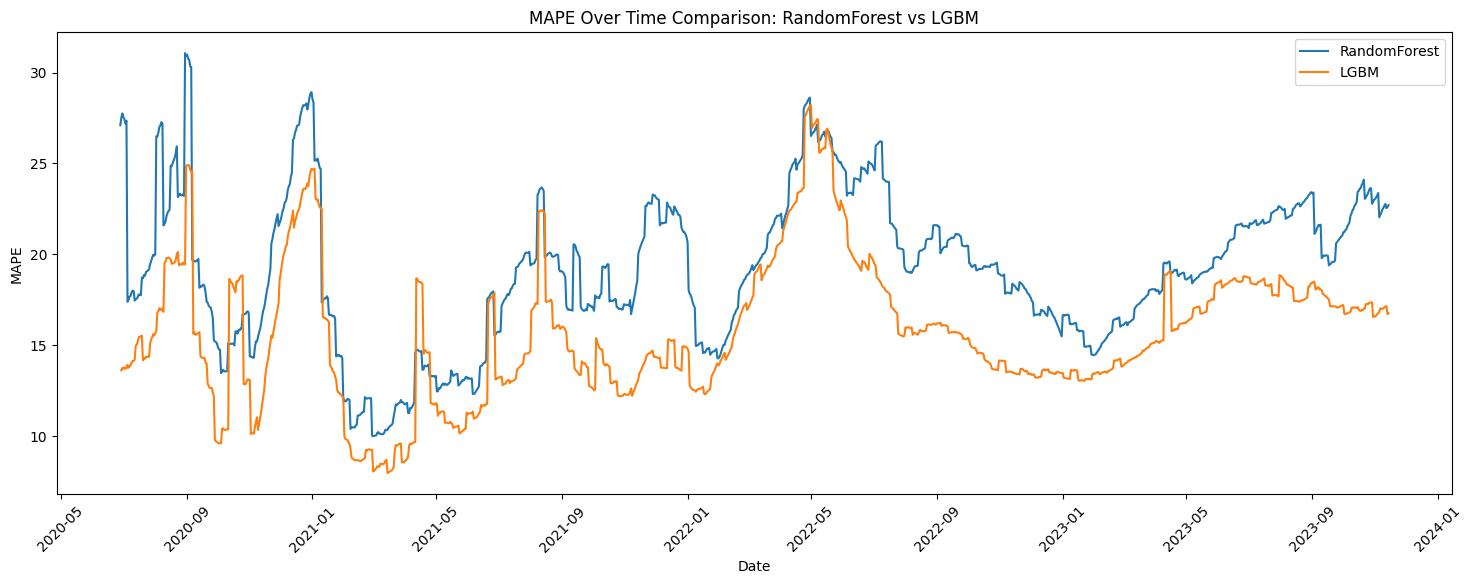

In [ ]:
width = 18 
height = 6 
plt.figure(figsize=(width, height))

# Plot RF MAPE
plt.plot(dates_rf, mape_values_rf, label='RandomForest')

# Plot LGBM MAPE
plt.plot(dates_lgbm, mape_values_lgbm, label='LGBM')

plt.xlabel('Date')
plt.ylabel('MAPE')
plt.title('MAPE Over Time Comparison: RandomForest vs LGBM')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# End Timestamp

In [86]:
end_time = time.time()

elapsed_time_seconds = end_time - start_time
elapsed_minutes = int(elapsed_time_seconds // 60)
elapsed_seconds = int(elapsed_time_seconds % 60)

print("Elapsed time:", elapsed_minutes, "minutes and", elapsed_seconds, "seconds")

Elapsed time: 89 minutes and 38 seconds
